# Employment and wage data by metro area

In [1]:
import pandas as pd
import requests
import warnings
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Set current working directory
os.chdir(os.getcwd() + "/Desktop/Metro Job Markets")

warnings.filterwarnings('ignore')

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Manual inputs based on BLS data release schedule
year_past = "2016"
year_current = "2019"
years = ['current', '2018', '2017', '2016']

### 1. Gathering data

1.1 Static reference tables

In [3]:
# Import reference table that maps FIPS codes to cleaned metropolitan area names
metro_codes = pd.read_excel('metro_fips.xlsx')
metro_codes.head()

,FIPS,Name
0,28180,"Kapaa, HI"
1,28260,"Kearney, NE"
2,28300,"Keene, NH"
3,28020,"Kalamazoo, MI"
4,28060,"Kalispell, MT"


In [4]:
# Import reference table that maps each occupation code to 1 = skilled labor or 0 = unskilled labor
# Unskilled labor: Menial or repetitive tasks are typical unskilled labor positions. Jobs that can be fully learned in less than 30 days often fall into the unskilled labor category.

labor_types = pd.read_excel('skilled_unskilled_classifications.xlsx')
labor_types.head()

,Occupation code,Occupation title,Skilled labor classification
0,11-1011,Chief Executives,1
1,11-1021,General and Operations Managers,1
2,11-1031,Legislators,1
3,11-2021,Marketing Managers,1
4,11-2022,Sales Managers,1


1.2 Get metro populations from [Census API](https://www.census.gov/data/developers/data-sets/popest-popproj/popest.html)

In [5]:
census_url = 'https://api.census.gov/data/2019/pep/population?get=NAME,POP&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*'
census_query = requests.get(census_url)
metro_pop = pd.DataFrame(json.loads(census_query.text))
metro_pop = metro_pop.drop(0)

metro_pop.columns = ['Name', 'Population', 'FIPS']
metro_pop['FIPS'] = metro_pop['FIPS'].astype('int64')
metro_pop['Population'] = metro_pop['Population'].astype('int64')

metro_pop['Size'] = metro_pop['Population'].apply(lambda x: "Large metro (pop. >1M)" if x > 1000000 else ("Mid-sized metro (pop. >500K)" if x > 500000 else "Small metro (pop. <500K)"))

metro_pop.head()

,Name,Population,FIPS,Size
1,"Ames, IA Metro Area",123351,11180,Small metro (pop. <500K)
2,"Amsterdam, NY Micro Area",49221,11220,Small metro (pop. <500K)
3,"Anchorage, AK Metro Area",396317,11260,Small metro (pop. <500K)
4,"Andrews, TX Micro Area",18705,11380,Small metro (pop. <500K)
5,"Angola, IN Micro Area",34594,11420,Small metro (pop. <500K)


1.3 Get metro % of population with bachelor's degree

In [6]:
def get_college_degree_counts(year):
    
    census_acs_url = f'https://api.census.gov/data/{year}/acs/acs5?get=NAME,B01003_001E,B15002_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*'
    census_acs_query = requests.get(census_acs_url)
    metro_degree = pd.DataFrame(json.loads(census_acs_query.text))
    metro_degree = metro_degree.drop(0)

    metro_degree.columns = ['Metro', 'Population', 'Bachelors Degree', 'FIPS']

    metro_degree['FIPS'] = metro_degree['FIPS'].astype('int64')
    metro_degree['Bachelors Degree'] = metro_degree['Bachelors Degree'].astype('int64')
    metro_degree['Population'] = metro_degree['Population'].astype('int64')

    metro_degree['% of Pop with Bachelors Degree'] = round(metro_degree['Bachelors Degree']/metro_degree['Population'], 3)
    metro_degree['Year'] = year
    
    metro_degree = metro_degree[['Metro', 'FIPS', 'Year', '% of Pop with Bachelors Degree']]
    
    return(metro_degree)

1.4 Scrape employment and wage data from [Bureau of Labor Statistics](https://www.bls.gov/oes/tables.htm) tables

In [7]:
def get_oews(year, fips):
    
    if year == 'current':
        period = 'current'
    else:
        period = year + '/may'
        
    metro_fips = fips

    oews_url = f'https://www.bls.gov/oes/{period}/oes_{metro_fips}.htm'
    html = requests.get(oews_url).content
    df = pd.read_html(html)
    
    df = df[-1]
    df = df[df['Level'] == 'detail']
    
    df = df[['Occupation code', 'Occupation title (click on the occupation title to view its profile)', 'Employment',
            'Employment per 1,000 jobs', 'Location quotient', 'Median hourly wage', 'Annual mean wage']]
    
    df.columns = ['Occupation code', 'Occupation title', 'Employment', 'Employment per 1,000 jobs', 
                  'Location quotient', 'Median hourly wage', 'Annual mean wage']
    
    colstocheck = df.columns
    df[colstocheck] = df[colstocheck].replace({'\$':''}, regex = True)
    df[colstocheck] = df[colstocheck].replace({'\(8\)': np.nan}, regex = True)
    df[colstocheck] = df[colstocheck].replace({'\(4\)': np.nan}, regex = True)
    df[colstocheck] = df[colstocheck].replace({'\(5\)': np.nan}, regex = True)
    df[colstocheck] = df[colstocheck].replace({',': ''}, regex = True)
    df[colstocheck] = df[colstocheck].replace({'\%': ''}, regex = True)
    
    df['Employment'] = pd.to_numeric(df['Employment'])
    df['Employment per 1,000 jobs'] = pd.to_numeric(df['Employment per 1,000 jobs'])
    df['Location quotient'] = pd.to_numeric(df['Location quotient'])
    df['Median hourly wage'] = pd.to_numeric(df['Median hourly wage'])
    df['Annual mean wage'] = pd.to_numeric(df['Annual mean wage'])
    
    df['Year'] = year
    df['FIPS'] = fips
    
    return(df)
    

In [8]:
#master_data = pd.DataFrame()

#for yr in years:
#    print(yr)
#    for fips in metro_codes['FIPS']:
#        try:
#            temp_data = get_oews(yr, fips)
#            master_data = pd.concat([master_data, temp_data])
#        except:
#            continue

In [9]:
#master_data.to_excel('occupational data by metro.xlsx', index = False)

### 2. Structuring the data

In [10]:
# Only need to scrape data from HTML tables the first time if you save the data
master_data = pd.read_excel('occupational data by metro.xlsx')

In [11]:
# Clean-up the appearance of our occupation data, bring in metro names
master_data = master_data.merge(metro_codes, left_on='FIPS', right_on='FIPS', how='left')
master_data['Year'] = master_data['Year'].apply(lambda x: '2019' if x == 'current' else x)
master_data = master_data[['Year','Name', 'FIPS', 'Occupation title', 'Occupation code', 'Employment', 'Employment per 1,000 jobs', 'Location quotient', 'Median hourly wage', 'Annual mean wage']]

master_data.head()

,Year,Name,FIPS,Occupation title,Occupation code,Employment,"Employment per 1,000 jobs",Location quotient,Median hourly wage,Annual mean wage
0,2019,"Kalamazoo, MI",28020,Chief Executives,11-1011,90.0,0.601,0.43,NaN,212380.0
1,2019,"Kalamazoo, MI",28020,General and Operations Managers,11-1021,2370.0,16.470,1.01,43.67,104920.0
2,2019,"Kalamazoo, MI",28020,Legislators,11-1031,50.0,0.353,0.99,NaN,49120.0
3,2019,"Kalamazoo, MI",28020,Marketing Managers,11-2021,100.0,0.693,0.39,43.25,104180.0
4,2019,"Kalamazoo, MI",28020,Sales Managers,11-2022,280.0,1.928,0.70,58.93,147180.0


2.1 Total employment calculations

In [12]:
master_data_current = master_data[master_data['Year'] == year_current]
master_data_past = master_data[master_data['Year'] == year_past]

relevant_cols = ['Name', 'FIPS', 'Employment']
master_data_current = master_data_current[relevant_cols]
master_data_past = master_data_past[relevant_cols]

master_data_current = master_data_current.groupby(['Name','FIPS'])['Employment'].sum().reset_index()
master_data_past = master_data_past.groupby(['Name','FIPS'])['Employment'].sum().reset_index()

master_data_totals = pd.merge(master_data_current, master_data_past, on = ["Name", "FIPS"], how = "left", suffixes=('_current', '_past'))

master_data_totals['% change in jobs'] = round((master_data_totals['Employment_current'] - master_data_totals['Employment_past'])/master_data_totals['Employment_past'], 3)

master_data_totals

,Name,FIPS,Employment_current,Employment_past,% change in jobs
0,"Abilene, TX",10180,55970.0,53860.0,0.039
1,"Aguadilla, PR",10380,35180.0,34860.0,0.009
2,"Akron, OH",10420,297790.0,308830.0,-0.036
3,"Albany, GA",10500,46760.0,49370.0,-0.053
4,"Albany, NY",10580,423840.0,429540.0,-0.013
...,...,...,...,...,...
370,"Yakima, WA",49420,83570.0,77020.0,0.085
371,"York, PA",49620,160920.0,166880.0,-0.036
372,"Youngstown, OH",49660,192870.0,206550.0,-0.066
373,"Yuba City, CA",49700,35860.0,33880.0,0.058


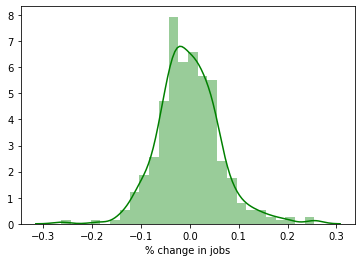

In [13]:
# Check to see distribution of 5-yr % change in jobs
master_data_totals_dist = master_data_totals.dropna()
sns.distplot(master_data_totals_dist['% change in jobs'], kde=True, rug=False, color = "Green")
plt.show()

2.2 Add skilled labor data to table

In [14]:
skilled_labor = master_data.merge(labor_types, left_on='Occupation code', right_on='Occupation code', how='left')
skilled_labor.head()

,Year,Name,FIPS,Occupation title_x,Occupation code,Employment,"Employment per 1,000 jobs",Location quotient,Median hourly wage,Annual mean wage,Occupation title_y,Skilled labor classification
0,2019,"Kalamazoo, MI",28020,Chief Executives,11-1011,90.0,0.601,0.43,NaN,212380.0,Chief Executives,1
1,2019,"Kalamazoo, MI",28020,General and Operations Managers,11-1021,2370.0,16.470,1.01,43.67,104920.0,General and Operations Managers,1
2,2019,"Kalamazoo, MI",28020,Legislators,11-1031,50.0,0.353,0.99,NaN,49120.0,Legislators,1
3,2019,"Kalamazoo, MI",28020,Marketing Managers,11-2021,100.0,0.693,0.39,43.25,104180.0,Marketing Managers,1
4,2019,"Kalamazoo, MI",28020,Sales Managers,11-2022,280.0,1.928,0.70,58.93,147180.0,Sales Managers,1


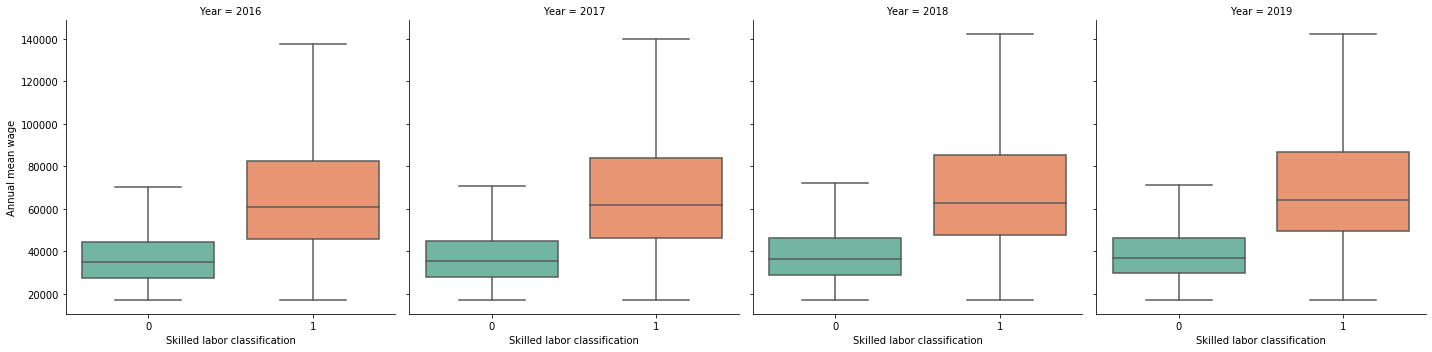

In [15]:
# Sense check the manual skilled labor classifications
sns.catplot(x="Skilled labor classification", y="Annual mean wage", col="Year",
            data=skilled_labor, palette="Set2", kind="box", showfliers=False)
plt.show()

2.3 Skilled vs. unskilled labor classification - Employment

In [16]:
skilled_labor['Skilled labor'] = skilled_labor['Employment'] * skilled_labor['Skilled labor classification']
skilled_labor['Skilled labor per 1,000 jobs'] = skilled_labor['Employment per 1,000 jobs'] * skilled_labor['Skilled labor classification']

skilled_labor = skilled_labor.groupby(['Year', 'Name','FIPS'])['Skilled labor', 'Skilled labor per 1,000 jobs'].sum().reset_index()

skilled_labor.tail()

,Year,Name,FIPS,Skilled labor,"Skilled labor per 1,000 jobs"
1491,2019,"Yakima, WA",49420,23560.0,251.972
1492,2019,"York, PA",49620,48370.0,264.503
1493,2019,"Youngstown, OH",49660,59470.0,281.995
1494,2019,"Yuba City, CA",49700,12030.0,267.895
1495,2019,"Yuma, AZ",49740,12760.0,205.753


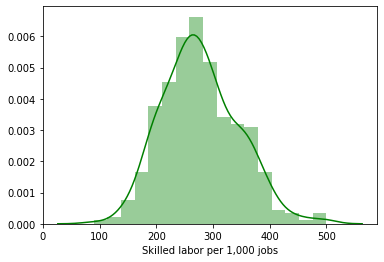

In [17]:
# Ensure that the numbers look realistic
skilled_labor_current = skilled_labor[skilled_labor['Year'] == "2019"]
sns.distplot(skilled_labor_current['Skilled labor per 1,000 jobs'], kde=True, rug=False, color = "Green")
plt.show()

2.4 Skilled vs. unskilled labor classification - 5 year percent change

In [18]:
skilled_labor_5YearsAgo = skilled_labor[skilled_labor['Year'] == year_past]
skilled_labor_current = skilled_labor[skilled_labor['Year'] == year_current]

skilled_labor_percChange = pd.merge(skilled_labor_current, skilled_labor_5YearsAgo, on = ["Name", "FIPS"], how = "left", suffixes=('_current', '_past'))

skilled_labor_percChange['Skilled labor change'] = round((skilled_labor_percChange['Skilled labor_current'] - skilled_labor_percChange['Skilled labor_past'])/skilled_labor_percChange['Skilled labor_past'], 3)
skilled_labor_percChange = skilled_labor_percChange[['Name', 'FIPS', 'Skilled labor_past', 'Skilled labor_current', 'Skilled labor change']]
skilled_labor_percChange = skilled_labor_percChange.sort_values(by=['Skilled labor change'], ascending=False)

skilled_labor_percChange = skilled_labor_percChange[['Name', 'FIPS', 'Skilled labor change']]

skilled_labor_percChange.head()

,Name,FIPS,Skilled labor change
77,"Columbus, IN",18020,0.695
167,"Jacksonville, NC",27340,0.542
72,"College Station, TX",17780,0.394
337,"The Villages, FL",45540,0.366
192,"Laredo, TX",29700,0.366


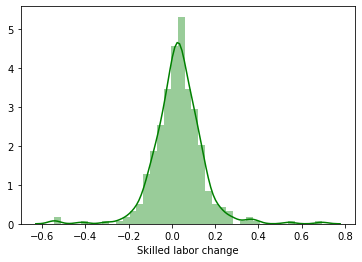

In [19]:
# Ensure that the numbers look realistic
skilled_labor_percChange_dist = skilled_labor_percChange.dropna()
sns.distplot(skilled_labor_percChange_dist['Skilled labor change'], kde=True, rug=False, color = "Green")
plt.show()

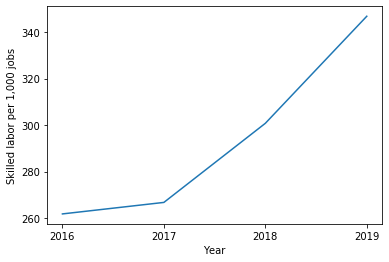

In [20]:
skilled_labor_metro = skilled_labor[skilled_labor['FIPS'] == 17780] # Example: College Station, TX
sns.lineplot(data=skilled_labor_metro, x="Year", y="Skilled labor per 1,000 jobs")

plt.show()

2.5 Bachelor's degree data

In [21]:
degree_current = get_college_degree_counts(year_current)
degree_past = get_college_degree_counts(year_past)

degrees = pd.merge(degree_current, degree_past, on = ["Metro", "FIPS"], how = "left", suffixes=('_current', '_past'))
degrees['Diff in Degrees'] = degrees['% of Pop with Bachelors Degree_current'] - degrees['% of Pop with Bachelors Degree_past']

degrees = degrees[['Metro', 'FIPS', '% of Pop with Bachelors Degree_current']]

degrees.head()

,Metro,FIPS,% of Pop with Bachelors Degree_current
0,"Big Stone Gap, VA Micro Area",13720,0.713
1,"Billings, MT Metro Area",13740,0.690
2,"Binghamton, NY Metro Area",13780,0.673
3,"Birmingham-Hoover, AL Metro Area",13820,0.684
4,"Bismarck, ND Metro Area",13900,0.683


### 3. Output

3.1 Construct final output tables

In [22]:
output = pd.merge(master_data_totals, skilled_labor_current, how="left", on=["Name", "FIPS"])
output = pd.merge(output, degrees, how="left", left_on=["FIPS"], right_on=["FIPS"])
output = pd.merge(output, metro_pop, how="left", left_on=["FIPS"], right_on=["FIPS"])

output = output[['Name_x', 'FIPS', 'Employment_current', '% change in jobs', 'Skilled labor per 1,000 jobs', '% of Pop with Bachelors Degree_current', 'Size']]

output

,Name_x,FIPS,Employment_current,% change in jobs,"Skilled labor per 1,000 jobs",% of Pop with Bachelors Degree_current,Size
0,"Abilene, TX",10180,55970.0,0.039,263.174,0.633,Small metro (pop. <500K)
1,"Aguadilla, PR",10380,35180.0,0.009,230.773,0.715,Small metro (pop. <500K)
2,"Akron, OH",10420,297790.0,-0.036,335.480,0.690,Mid-sized metro (pop. >500K)
3,"Albany, GA",10500,46760.0,-0.053,226.640,0.654,Small metro (pop. <500K)
4,"Albany, NY",10580,423840.0,-0.013,389.636,0.691,Mid-sized metro (pop. >500K)
...,...,...,...,...,...,...,...
370,"Yakima, WA",49420,83570.0,0.085,251.972,0.606,Small metro (pop. <500K)
371,"York, PA",49620,160920.0,-0.036,264.503,0.697,Small metro (pop. <500K)
372,"Youngstown, OH",49660,192870.0,-0.066,281.995,0.712,Mid-sized metro (pop. >500K)
373,"Yuba City, CA",49700,35860.0,0.058,267.895,0.642,Small metro (pop. <500K)


3.2 Ranks by metro type

In [23]:
output_large = output[output['Size'] == "Large metro (pop. >1M)"]
output_mid = output[output['Size'] == "Mid-sized metro (pop. >500K)"]
output_small = output[output['Size'] == "Small metro (pop. <500K)"]

output_large['Skilled Rank'] = round(output_large['Skilled labor per 1,000 jobs'].rank(pct = True), 2)
output_mid['Skilled Rank'] = round(output_mid['Skilled labor per 1,000 jobs'].rank(pct = True), 2)
output_small['Skilled Rank'] = round(output_small['Skilled labor per 1,000 jobs'].rank(pct = True), 2)

output_large['Degree Rank'] = round(output_large['% of Pop with Bachelors Degree_current'].rank(pct = True), 2)
output_mid['Degree Rank'] = round(output_mid['% of Pop with Bachelors Degree_current'].rank(pct = True), 2)
output_small['Degree Rank'] = round(output_small['% of Pop with Bachelors Degree_current'].rank(pct = True), 2)

output_final = pd.concat([output_large, output_mid, output_small])
output_final


,Name_x,FIPS,Employment_current,% change in jobs,"Skilled labor per 1,000 jobs",% of Pop with Bachelors Degree_current,Size,Skilled Rank,Degree Rank
19,"Atlanta, GA",12060,2575160.0,0.028,386.800,0.662,Large metro (pop. >1M),0.73,0.18
23,"Austin, TX",12420,992840.0,0.057,395.012,0.670,Large metro (pop. >1M),0.82,0.26
25,"Baltimore, MD",12580,1295500.0,-0.011,400.679,0.692,Large metro (pop. >1M),0.88,0.75
35,"Birmingham, AL",13820,483970.0,-0.013,345.966,0.684,Large metro (pop. >1M),0.25,0.58
47,"Buffalo, NY",15380,513130.0,-0.042,336.982,0.705,Large metro (pop. >1M),0.22,0.90
...,...,...,...,...,...,...,...,...,...
368,"Winchester, VA",49020,49310.0,0.031,248.562,0.693,Small metro (pop. <500K),0.47,0.70
370,"Yakima, WA",49420,83570.0,0.085,251.972,0.606,Small metro (pop. <500K),0.50,0.08
371,"York, PA",49620,160920.0,-0.036,264.503,0.697,Small metro (pop. <500K),0.61,0.76
373,"Yuba City, CA",49700,35860.0,0.058,267.895,0.642,Small metro (pop. <500K),0.64,0.24


In [24]:
output_final['Skilled labor per 100 jobs'] = round(output_final['Skilled labor per 1,000 jobs']/10, 1)
output_final['College degrees per 100'] = output_final['% of Pop with Bachelors Degree_current']*100

output_final['Skilled color'] = output_final['Skilled Rank'].apply(lambda x: "green" if x > 0.5 else "red")
output_final['Degree color'] = output_final['Degree Rank'].apply(lambda x: "green" if x > 0.5 else "red")

output_final = output_final[['Name_x', '% change in jobs', 'Employment_current', 'Skilled labor per 100 jobs',
                             'College degrees per 100', 'Skilled color', 'Degree color', 'Size']]

output_final.columns = ['Metro', 'Change in jobs', 'Employment', 'Skilled labor per 100 jobs', 'College degrees per 100 people', 'Skilled color', 'Degree color', 'Size']

output_final

,Metro,Change in jobs,Employment,Skilled labor per 100 jobs,College degrees per 100 people,Skilled color,Degree color,Size
19,"Atlanta, GA",0.028,2575160.0,38.7,66.2,green,red,Large metro (pop. >1M)
23,"Austin, TX",0.057,992840.0,39.5,67.0,green,red,Large metro (pop. >1M)
25,"Baltimore, MD",-0.011,1295500.0,40.1,69.2,green,green,Large metro (pop. >1M)
35,"Birmingham, AL",-0.013,483970.0,34.6,68.4,red,green,Large metro (pop. >1M)
47,"Buffalo, NY",-0.042,513130.0,33.7,70.5,red,green,Large metro (pop. >1M)
...,...,...,...,...,...,...,...,...
368,"Winchester, VA",0.031,49310.0,24.9,69.3,red,green,Small metro (pop. <500K)
370,"Yakima, WA",0.085,83570.0,25.2,60.6,red,red,Small metro (pop. <500K)
371,"York, PA",-0.036,160920.0,26.5,69.7,green,green,Small metro (pop. <500K)
373,"Yuba City, CA",0.058,35860.0,26.8,64.2,green,red,Small metro (pop. <500K)


In [25]:
# Export to JSON for easy input into Observable
output_final.to_csv('Jobs data - national view.csv', index = False)